# patchOTDA
## What is this?
The aim of this package is to facilitate the integration of patch clamp electrophysiology datasets. Due to the sensitivity of patch clamp electrophysiological recordings to a variety of different extraneous variables, for example, temperature, solution, region, etc.
![](assets/dataset_drift.PNG)  

patchOTDA is a small python package that wraps several optimal transport based domain adaptation packages. The package aims to help intermediate users integrate two datasets by following simple OOP conventions.  
 
End users are encouraged to check out the streamlit app: https://patchotda.streamlit.app/. This app allows you to integrate your dataset with a reference dataset from the Allen Institute.


## Quickstart

### Install

The package is not currently available on pip but can be installed by pulling the git repo

```
pip install git+https://github.com/smestern/pypatchOTDA.git
```

Should install the packages and their dependencies.
To use SKADA, and FUGW transporters, the user will need to install these additional dependencies manually

```
pip install git+https://github.com/scikit-adaptation/skada
pip install unbalancedgw
```

### Basic usage

The basic patchOTDA object is a wrapper around the POT domain adaptation method(s). Here we implement a few error catches and manipulations to allow the user to easily plug and play their data.
To begin with, you can initiate the patchOTDA object

dict_keys(['CTKE_M1', 'VISp_Viewer', 'Query1', 'Query2', 'Query3', 'joint_feats'])


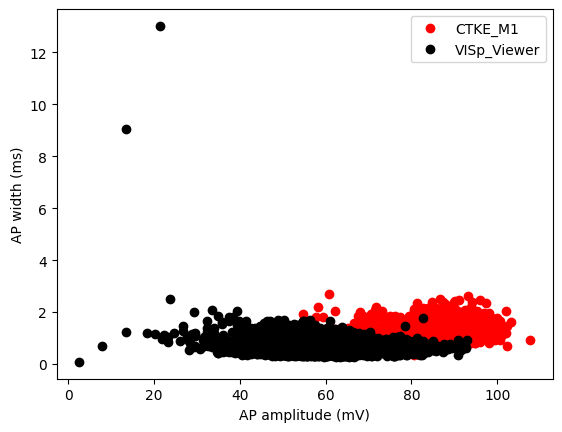

In [17]:
import patchOTDA.domainAdapt as pOTDA
from patchOTDA.datasets import MMS_DATA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

da = pOTDA.PatchClampOTDA()

# Load data
Xs = MMS_DATA['CTKE_M1']['ephys']
Xt = MMS_DATA['VISp_Viewer']['ephys']
print(MMS_DATA.keys())
#make sure the features are the same
Xs = Xs.loc[:,MMS_DATA['joint_feats']].to_numpy()
Xt = Xt.loc[:,MMS_DATA['joint_feats']].to_numpy()

plt.plot(Xt[:,0],Xt[:,1],'o', c='k', label='VISp_Viewer')
plt.plot(Xs[:,0],Xs[:,1],'o', c='r', label='CTKE_M1')
plt.xlabel(MMS_DATA['joint_feats'][0])
plt.ylabel(MMS_DATA['joint_feats'][1])
plt.legend()


#### Preprocessing
Scaling is a needed step, as the OT methods can be unstable to converge if the scales are large.  
In most cases its good practice to scale and impute (remove NaNs) prior to applying a domain adaptation method.   
In standard ML practice, it's a good idea to apply preprocessing steps to each dataset independently.   
This is also applicable here, however, sometimes, we want to apply our scaler to the same dataset -> if we are using a LinearOTmapping etc. so we can properly learn the difference between the datasets.

In [20]:
# Preprocess data
scaler = StandardScaler()
imputer = SimpleImputer(strategy='mean')
Xs = imputer.fit_transform(Xs)
Xt = imputer.transform(Xt)
Xs = scaler.fit_transform(Xs)
Xt = scaler.transform(Xt)

#### Transforming your data
The transporter follows the fit, fit_transform conventions as introduced in the POT package 

/home/smestern/anaconda3/envs/patchOTDA/lib/python3.11/site-packages/ot/lp/__init__.py:361: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


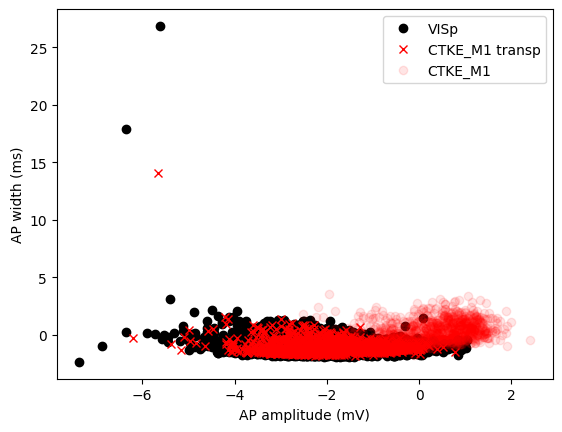

In [23]:
# Fit model
da.fit(Xs, Xt)
#transport
Xs_transp = da.transform(Xs, Xt)
plt.plot(Xt[:,0],Xt[:,1],'o', c='k', label='VISp')
plt.plot(Xs_transp[:,0],Xs_transp[:,1],'x', c='r', label='CTKE_M1 transp')
plt.plot(Xs[:,0],Xs[:,1],'o', c='r', label='CTKE_M1', alpha=0.1)
plt.xlabel(MMS_DATA['joint_feats'][0])
plt.ylabel(MMS_DATA['joint_feats'][1])
plt.legend()

## Tuning the transporter